In [1]:
using BSON, CUDA, Dates, DelimitedFiles, Downloads, Flux, Plots

include("simulation.jl");
include("neural.jl");
include("generateVext.jl");

In [2]:
BSON.@load "model.bson" model
display(model)

Chain(
  Dense(551 => 512, softplus),          # 282_624 parameters
  Dense(512 => 256, softplus),          # 131_328 parameters
  Dense(256 => 128, softplus),          # 32_896 parameters
  Dense(128 => 64, softplus),           # 8_256 parameters
  Dense(64 => 32, softplus),            # 2_080 parameters
  Dense(32 => 1),                       # 33 parameters
)                   # Total: 12 arrays, 457_217 parameters, 1.745 MiB.

In [3]:
function get_c1_neural(model, ϕ)
    window_bins = length(model.layers[1].weight[1,:])-size(ϕ)[1] # Get the number of input bins from the shape of the first layer
    model = model |> gpu
    function (ρ, ϕ)
        ρ_windows = generate_windows(ρ; window_bins) |> gpu
        ϕ_func = generate_phi(ϕ, ρ) |> gpu
        input = vcat(ρ_windows, ϕ_func)
        model(input) |> cpu |> vec  # Evaluate the model, make sure the result gets back to the CPU, and transpose it to a vector
    end
end

get_c1_neural (generic function with 1 method)

In [4]:
#some possible pair potentials
Lj(x, ϵ) = 4*ϵ*((σ/x)^12-(σ/x)^6) # LJ

function H(x) #ramp
    if 0 <= x < 1
        return -0.5*x+1.5
    else
        return 0
    end
end

function B(x, ϵ) #box
    if 0 <= x < 1
        return ϵ
    else
        return 0
    end
end

HR(x) = x < 1 ? Inf : 0 #hard rods

HR (generic function with 1 method)

Converged (step: 377, ‖Δρ‖ = 5.9843063e-5 < 6.103515625e-5 = tolerance)


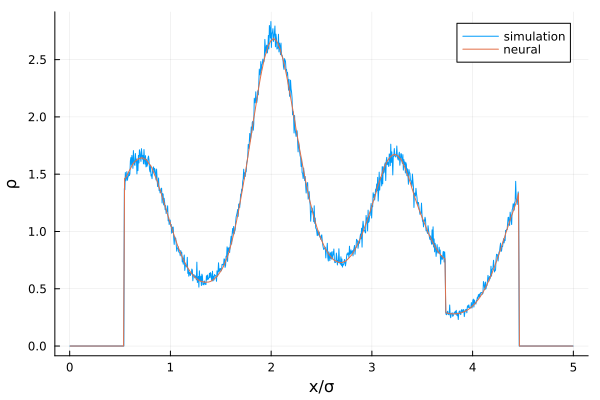

In [6]:
L = 5
T = 1.5 
μ = 1.0

sin_parameters, lin_parameters, wall_params = Generateparams(L)
Vextg(x) = GenerateV(x, sin_parameters, lin_parameters, wall_params) #generate random external potential

xs1, ρ1 = simulate(L, μ, T, Vextg, H; equilibration_time=Dates.Second(1), production_time=Dates.Second(2), sweep_transitions=10)
xs2, ρ2 = MINIMIZE(L, μ, T, H, Vextg, model)
plot(xs1, ρ1, label="simulation", xlabel="x/σ", ylabel="ρ")
plot!(xs2, ρ2, label="neural")